In [1]:
import fix_project_path

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from evaluate.segmentations import do_property_binning
from config import basepaths
from config import Config
from config.datasets import datasets
from config.repositories import repositories
from datasets.loader import load_data, DataFoldFactory
from evaluate.segmentations import do_event_dissection
from experiment import ExperimentKeys
from paths import ExperimentPaths, makedirs


%load_ext autoreload
%autoreload 2

In [2]:
data_keys = {
    #'gazebase_all_sr1000_sl1000_dxy': "GazeBase (1000 s)",
    #'gazebase_all_sr1000_sl5000_savgol_maxvel500_dxy': "GazeBase",# (5000 s)",
    #'gazebase_all_sr1000_sl5000_savgol_maxvel750_dxy': "GazeBase",# (5000 s)",
    'gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy': "GazeBase",# (5000 s)",

    #'judo_sr1000_sl1000_rxy': "JuDo1000 (right eye)",
    #'judo_sr1000_sl1000_savgol_maxvel500_bxy': "JuDo1000",# (both eyes)",
    #'judo_sr1000_sl1000_savgol_maxvel750_bxy': "JuDo1000",# (both eyes)",
    'judo_sr1000_sl1000_savgol_maxvel1000_bxy': "JuDo1000",# (both eyes)",

    #'potec_sr1000_sl1000_savgol_maxvel500_dxy': "PoTeC",
    #'potec_sr1000_sl1000_savgol_maxvel750_dxy': "PoTeC",
    'potec_sr1000_sl1000_savgol_maxvel1000_dxy': "PoTeC",
}


model_keys = {
    'eky2': "EKY2",
    #'del_slow': "DELslow",
    #'del_fast_zstd': "DELfast0",
    #'del_zstd': "DEL0",
    #'del_fast_vmin1': "DELfast1",
    #'del_vmin1': "DEL1",
    #'del_fast_vmin4': "DELfast",
    #'del_vmin4': "DEL",
    #'del_fast_vmin10': "DELfast10",
    #'del_vmin10': "DEL",
    #'del_fast': "DELfast40",
    #'del': "DEL40",
}

explainer_keys = {
    'deeplift_zero': 'DL',
    #'input_x_gradient': 'IxG',
    'integrated_gradients_zero': 'IG',
    #'occlusion_s3': 'Occ(3)',
    #'occlusion_s5': 'Occ(5)',

    #'lrp_epsilon0_only': 'LRP-ε0',
    'lrp_epsilon0.25_only': 'LRP',#-Ε',
    #'lrp_epsilon1e-6_only': 'LRP-ε',
    
    #'lrp_epsilon_plus': 'LRP-ε+',
    #'lrp_epsilon_plus_flat': 'LRP-ε+♭',
    
    #'lrp_epsilon_gamma0.25': 'LRP-γ',
    #'lrp_epsilon_gamma0.25_flat': 'LRP-γ♭',
    #'lrp_epsilon_gamma0.1': 'LRP-εγ.1',
    #'lrp_epsilon_gamma0.1_flat': 'LRP-εγ.1♭',

    #'lrp_epsilon_alpha2_beta1': 'LRP-α2β1',
    #'lrp_epsilon_alpha2_beta1_flat': 'LRP-α2β1♭',
    #'lrp_epsilon_alpha1_beta0': 'LRP-α1β0',
    #'lrp_epsilon_alpha1_beta0_flat': 'LRP-α1β0♭',
}

metric_keys = {
    #'area_under_curve': 'score',
    #'attribution_localisation': 'score',
    #'attribution_localisation_weighted': 'score',
    #'localized_attribution_aggregate_max': 'score',
    #'localized_attribution_aggregate_mean': 'score',
    #'localized_attribution_aggregate_median': 'score',
    #'pointing_game': 'score',
    #'pointing_game_weighted': 'score',
    #'relevance_mass_accuracy': 'score',
    #'top_1_percent_intersection': 'score',
    #'top_1_percent_intersection_concept_influence': 'score',
    'top_2_percent_intersection': 'top k intersection',
    'top_2_percent_intersection_concept_influence': 'concept influence',
    #'top_5_percent_intersection': 'score',
    #'top_5_percent_intersection_concept_influence': 'score',
    #'top_10_percent_intersection': 'score',
    #'top_10_percent_intersection_concept_influence': 'score',
    #'top_20_percent_intersection': 'score',
    #'top_20_percent_intersection_concept_influence': 'score',
}

segmentation_keys = {
    #'clip': 'clip',
    #'nan': 'nan',
    #'engbert.fixation': 'fixation',
    'engbert.saccade_dissection_vpeak80': 'saccade',
    #'engbert.saccade.monocular': 'saccade.monocular',
}



base_segmentation_key = 'engbert.saccade'
dissection_key = 'vpeak80'

sections = {
    0: 'pre',
    1: 'rise',
    2: 'peak',
    3: 'basin',
    4: 'fall',
    5: 'post',
}

basepath = Path('/mnt/scratch/krakowczyk/workspace/xai-timeseries/')

In [3]:
velocities = {}
fold_indices = {}
dataset_sizes = {}

for data_key in tqdm(data_keys):
    keys = ExperimentKeys(data_key=data_key)
    config = Config(experiment_keys=keys)
    paths = ExperimentPaths(basepath=basepaths.workspace, config=config)
    data = load_data(config=config, paths=paths)
    
    fold_indices[data_key] = data['folds']
    dataset_sizes[data_key] = len(data['X'])
    velocities[data_key] = data['X']
    
    del data

  0%|          | 0/3 [00:00<?, ?it/s]

Selected input channels: ['dx', 'dy']
X.shape: (67483, 5000, 2)
Y.shape: (67483, 100)
Folds: [1, 2, 3, 4]
Selected input channels: ['dxr', 'dyr', 'dxl', 'dyl']
X.shape: (172623, 1000, 4)
Y.shape: (172623, 150)
Folds: [1, 2, 3, 4]
Selected input channels: ['dx', 'dy']
X.shape: (107540, 1000, 2)
Y.shape: (107540, 75)
Folds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [4]:
segmentations = {}
properties = {}

for data_key in tqdm(data_keys):
    repo_key = datasets[data_key]['repo_key']
    repo_path = Path(repositories[repo_key]['dirpath'])
    
    event_dirpath = basepath / repo_path / 'events'
    segmentation_filepath = event_dirpath / f'{base_segmentation_key}.npy'
    properties_filepath = event_dirpath / f'{base_segmentation_key}.csv'

    if not segmentation_filepath.exists():
        print('skip', segmentation_filepath)
        continue
        
    if not properties_filepath.exists():
        print('skip', properties_filepath)
        continue
        
    segmentations[data_key] = np.load(segmentation_filepath)

    properties_dataset = pd.read_csv(properties_filepath)
    properties_dataset['data'] = data_key
    properties[data_key] = properties_dataset



  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dfs = []

for data_key in data_keys:
    index = pd.MultiIndex.from_product(
        iterables=[
            [data_key],
            model_keys.keys(),
            explainer_keys.keys(),
            metric_keys.keys(),
            sections.values(),
            range(dataset_sizes[data_key])
        ],
        names=['data', 'model', 'explainer', 'metric', 'section', 'instance_id'],
    )

    df = pd.DataFrame(index=index, columns=['score', 'fold'])

    for fold_id, fold_masks in fold_indices[data_key].items():
        test_mask = fold_masks['test']
        test_idx = np.where(test_mask)[0]
        df.loc[df.index.get_level_values('instance_id').isin(test_idx)] = fold_id

    dfs.append(df)

scores = pd.concat(dfs)
del dfs

scores.sort_index(inplace=True)

display(scores)

score  \
data                                             model explainer            metric                                       section instance_id         
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   basin   0               1   
                                                                                                                                 1               1   
                                                                                                                                 2               1   
                                                                                                                                 3               1   
                                                                                                                                 4               1   
...                                                                                                                                            ...   
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence rise    107535         11   
                                                                                                                                 107536         11   
                                                                                                                                 107537         11   
                                                                                                                                 107538         11   
                                                                                                                                 107539         11   

                                                                                                                                             fold  
data                                             model explainer            metric                                       section instance_id       
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   basin   0              1  
                                                                                                                                 1              1  
                                                                                                                                 2              1  
                                                                                                                                 3              1  
                                                                                                                                 4              1  
...                                                                                                                                           ...  
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence rise    107535        11  
                                                                                                                                 107536        11  
                                                                                                                                 107537        11  
                                                                                                                                 107538        11  
                                                                                                                                 107539        11  

[12515256 rows x 2 columns]

In [6]:
scorepath_pattern = '/mnt/scratch/krakowczyk/workspace/xai-timeseries/evaluations/attribution_localization/{data_key}/{model_key}/{explainer_key}/{metric_key}/{segmentation_key}/scores.npy'

for data_key in tqdm(data_keys):
    for model_key in tqdm(model_keys.keys(), leave=False):
        for explainer_key in tqdm(explainer_keys.keys(), leave=False):
            for metric_key in tqdm(metric_keys.keys(), leave=False):
                for segmentation_key in tqdm(segmentation_keys.keys(), leave=False):
                    
                    filepath = Path(scorepath_pattern.format(
                        data_key=data_key,
                        model_key=model_key,
                        explainer_key=explainer_key,
                        metric_key=metric_key,
                        segmentation_key=segmentation_key,
                        #issection_key=dissection_key,
                    ))

                    if filepath.exists():
                        score = np.load(filepath)
                        
                        for section_id, section_name in sections.items():

                            result_idx = data_key, model_key, explainer_key, metric_key, section_name
                            scores.loc[result_idx, 'score'] = score[:, section_id]

                    else:
                        print(f'skip {filepath}')

display(scores)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

score  \
data                                             model explainer            metric                                       section instance_id              
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   basin   0                  NaN   
                                                                                                                                 1                  NaN   
                                                                                                                                 2                 0.03   
                                                                                                                                 3                  NaN   
                                                                                                                                 4                  0.0   
...                                                                                                                                                 ...   
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence rise    107535        6.451613   
                                                                                                                                 107536        4.166667   
                                                                                                                                 107537       16.666667   
                                                                                                                                 107538             6.0   
                                                                                                                                 107539        8.333333   

                                                                                                                                             fold  
data                                             model explainer            metric                                       section instance_id       
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   basin   0              1  
                                                                                                                                 1              1  
                                                                                                                                 2              1  
                                                                                                                                 3              1  
                                                                                                                                 4              1  
...                                                                                                                                           ...  
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence rise    107535        11  
                                                                                                                                 107536        11  
                                                                                                                                 107537        11  
                                                                                                                                 107538        11  
                                                                                                                                 107539        11  

[12515256 rows x 2 columns]

In [7]:
scores = scores.reset_index()

scores.data = scores.data.map(data_keys)
scores.model = scores.model.map(model_keys)
scores.explainer = scores.explainer.map(explainer_keys)
scores.metric = scores.metric.map(metric_keys)

display(scores)

,data,model,explainer,metric,section,instance_id,score,fold
0,GazeBase,EKY2,DL,top k intersection,basin,0,NaN,1
1,GazeBase,EKY2,DL,top k intersection,basin,1,NaN,1
2,GazeBase,EKY2,DL,top k intersection,basin,2,0.03,1
3,GazeBase,EKY2,DL,top k intersection,basin,3,NaN,1
4,GazeBase,EKY2,DL,top k intersection,basin,4,0.0,1
...,...,...,...,...,...,...,...,...
12515251,PoTeC,EKY2,LRP,concept influence,rise,107535,6.451613,11
12515252,PoTeC,EKY2,LRP,concept influence,rise,107536,4.166667,11
12515253,PoTeC,EKY2,LRP,concept influence,rise,107537,16.666667,11
12515254,PoTeC,EKY2,LRP,concept influence,rise,107538,6.0,11


In [8]:
dissections = {}

for data_key, data_name in data_keys.items():
    print(data_key)
    
    dataset_velocities = velocities[data_key]
    dataset_segmentation = segmentations[data_key]
    dataset_properties = properties[data_key]
    dataset_dissection = do_event_dissection(
        dataset_velocities, dataset_segmentation, dataset_properties, show_progress=True)

    dissections[data_key] = dataset_dissection

gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy


judo_sr1000_sl1000_savgol_maxvel1000_bxy


potec_sr1000_sl1000_savgol_maxvel1000_dxy


In [9]:
plot_dirpath = Path('/home/krakowczyk/workspace/xai-timeseries/plots/event_dissection/')
makedirs(plot_dirpath)

In [10]:
def plot_sizes(figsize=(6,3)):
    sns.set_theme(style = "whitegrid")#, font_scale=1.4)

    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    for plot_id, (data_key, data_name) in enumerate(data_keys.items()):
        dataset_ax = axs[plot_id]

        dataset_ax.set_title(data_name)
        if plot_id == 0:
            dataset_ax.set_ylabel('avg segmentation size')

        dataset_velocities = velocities[data_key]
        dataset_segmentation = segmentations[data_key]
        dataset_properties = properties[data_key]
        dataset_dissection = dissections[data_key]
        
        #section_names = [s for s in sections.values() if s != 'basin']
        section_names = [s for s in sections.values()]
        section_sizes = np.mean(dataset_dissection[:, [0, 1, 2, 3, 4, 5]], axis=(0,2))
        
        dataset_ax.bar(section_names, section_sizes)
        
        #dataset_ax.xaxis.set_ticks(section_names)
        dataset_ax.set_xticklabels(
            section_names,
                   rotation=45, 
                   horizontalalignment='right',
                   rotation_mode='anchor'
                  )


    plt.tight_layout(pad=0.8)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    savepath = plot_dirpath / 'event-dissection-saccade-size.pdf'
    plt.savefig(savepath)
    print(savepath)
    plt.show()


/tmp/ipykernel_3413573/154879325.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  dataset_ax.set_xticklabels(


/home/krakowczyk/workspace/xai-timeseries/plots/event_dissection/event-dissection-saccade-size.pdf


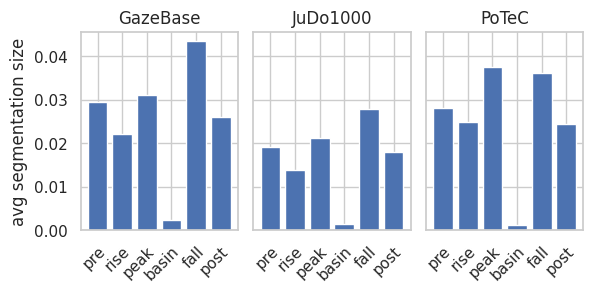

In [11]:
plot_sizes()

In [21]:
import matplotlib as mpl

def plot_metrics(figsize=(6,5)):
    sns.set_theme(style = "whitegrid", font_scale=1.3)
    #sns.set_style({'legend.frameon':False})

    for metric_key, metric_name in metric_keys.items():

        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
        for plot_id, (data_key, data_name) in enumerate(data_keys.items()):
            dataset_ax = axs[plot_id]

            dataset_ax.set_title(data_name)
            if plot_id == 0:
                dataset_ax.set_ylabel(metric_name)

            this_scores = scores[
                (scores.data == data_name) &
                (scores.metric == metric_name)# &
                #(scores.section != 'basin')
            ]
            sns.boxplot(
                data=this_scores,
                x='section',
                y='score',
                hue='explainer',
                ax=dataset_ax,
                showfliers=False,
                palette='deep',
                #order=['pre', 'rise', 'peak', 'basin', 'fall', 'post']
                order=['pre', 'rise', 'peak', 'fall', 'post']
            )
            
            dataset_ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=2))
            dataset_ax.set_xticklabels(dataset_ax.get_xticklabels(), 
                       rotation=45, 
                       horizontalalignment='right',
                       rotation_mode='anchor'
                      )
            
            dataset_ax.grid(False, which='major', axis='x')
            dataset_ax.grid(True, which='minor', axis='x')
            dataset_ax.grid(True, which='major', axis='y')
            dataset_ax.grid(False, which='minor', axis='y')
            dataset_ax.spines['top'].set_visible(False)

            dataset_ax.axhline(1, color='gray', linestyle='--')
            
            
            dataset_ax.set_xlabel(None)
            
            if plot_id == 0:
                dataset_ax.set_ylabel(metric_name)
            else:
                dataset_ax.set_ylabel(None)

            if plot_id != 2:
                dataset_ax.get_legend().remove()
            else:
                dataset_ax.get_legend().remove()
                #plt.legend(title=None)
              
        plt.tight_layout(pad=0.8)

        ax = plt.gca()
        ax.legend(
            ncol=3,
            loc='center', 
            bbox_to_anchor=(-0.75, -0.3),
        )
        #ax.legend(bbox_to_anchor=(1.05, 1.05))
        
        plt.subplots_adjust(hspace=0.1, wspace=0.1)
        
        savepath = plot_dirpath / f'event-dissection-saccade-{metric_key}.pdf'
        plt.savefig(savepath, bbox_inches='tight')
        print(savepath)
        plt.show()


/home/krakowczyk/workspace/xai-timeseries/plots/event_dissection/event-dissection-saccade-top_2_percent_intersection.pdf


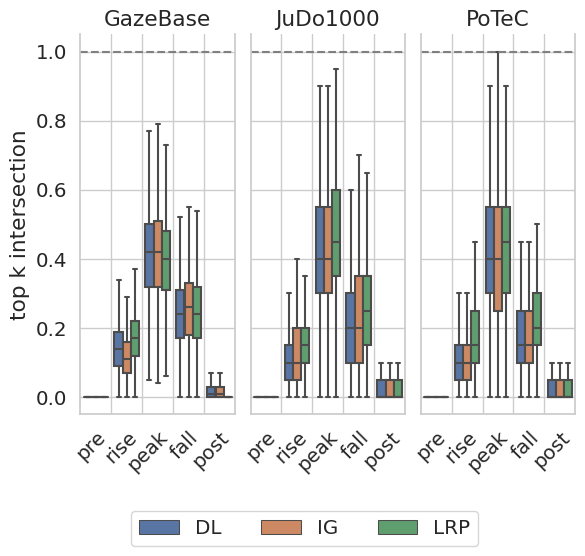

/home/krakowczyk/workspace/xai-timeseries/plots/event_dissection/event-dissection-saccade-top_2_percent_intersection_concept_influence.pdf


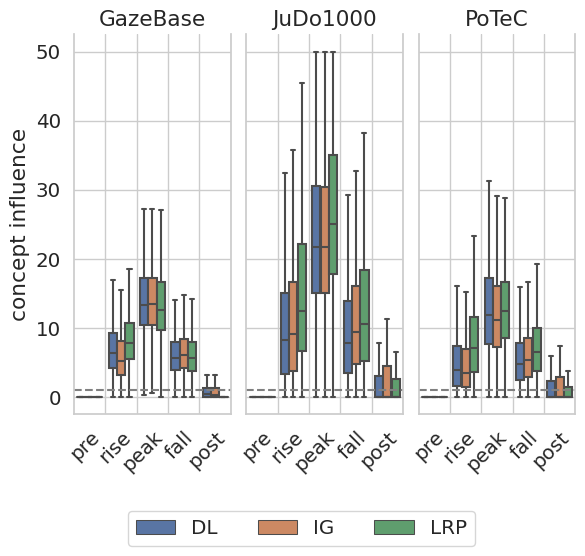

In [22]:
plot_metrics()